In [ ]:
# ! git clone https://github.com/awarebayes/RecNN
! pip install -r ./RecNN/requirements.txt
! pip install ./RecNN
! pip install gdown

In [1]:

import recnn
import torch
import torch.nn as nn
from tqdm.auto import tqdm

tqdm.pandas()

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

In [3]:
# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
frame_size = 10
batch_size = 25
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="",
    embeddings="ml-1m/ml20_pca128.pkl",
    ratings="ml-1m/ratings.csv",
    cache="cached_frame_env.pkl", 
    use_cache=True
)
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)

  0%|          | 0/20000263 [00:00<?, ?it/s]

  0%|          | 0/20000263 [00:00<?, ?it/s]

  0%|          | 0/138493 [00:00<?, ?it/s]

In [4]:
# get data
train = env.train_batch()
test = env.train_batch()
state, action, reward, next_state, done = recnn.data.get_base_batch(train, device=device)

In [7]:
# initialize
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2).to(device)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1).to(device)

In [8]:
# try recommending
recommendation = policy_net(state)
value = value_net(state, recommendation)

In [18]:
value

tensor([[-3.6300],
        [-1.4657],
        [-3.7290],
        ...,
        [-1.4493],
        [-5.5033],
        [ 0.1693]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [13]:
# wrap in the rl algorithm
ddpg = recnn.nn.DDPG(policy_net, value_net)
ddpg = ddpg.to(device)
plotter = recnn.utils.Plotter(ddpg.loss_layout, [['value','policy']])

In [15]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = ddpg.update(batch, learn=False)
    return loss

step 1000


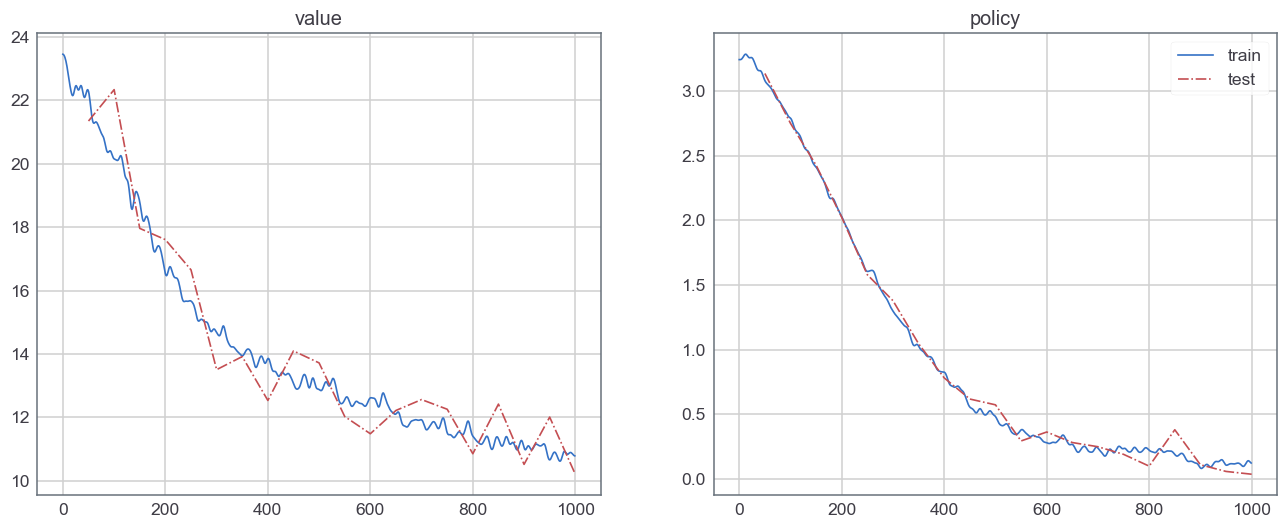

In [17]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2

def learn():
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = ddpg.update(batch, learn=True)
            plotter.log_losses(loss)
            ddpg.step()
            if ddpg._step % plot_every == 0:
                clear_output(True)
                print('step', ddpg._step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if ddpg._step > 1000:
                return
            
learn()